In [1]:
import tensorflow as tf
tf.__version__
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 8049664202858584108,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 595934691147848963
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 6918604064
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 11303894097069539987
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2080 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 17653763322453702539
 physical_device_desc: "device: XLA_GPU device"]

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
tf.debugging.set_log_device_placement(True)

a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
c = tf.matmul(a, b)
print(c)

Executing op MatMul in device /job:localhost/replica:0/task:0/device:GPU:0
tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


In [4]:
import keras
from keras.models import Sequential, Model
from keras import layers, applications, optimizers
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation,GlobalMaxPooling2D
from keras.preprocessing.image import ImageDataGenerator, load_img

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import random

In [5]:
epoch = 100
batch_size = 5
image_size = 224

In [6]:
#load train data(25000 imgs each)

filenames = os.listdir('./input/train/train')
data = []
categories = []

for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)
    
    image = keras.preprocessing.image.load_img(os.path.join('./input/train/train', filename),
                                               color_mode='rgb',
                                               target_size= (image_size,image_size))
    image = np.array(image)
    data.append(image)

data = np.array(data)
categories = np.array(categories)

print(data)
print(categories)

[[[[203 164  87]
   [206 167  90]
   [209 170  93]
   ...
   [245 203 119]
   [241 202 123]
   [239 200 121]]

  [[203 164  87]
   [206 167  90]
   [209 170  93]
   ...
   [245 205 120]
   [242 203 124]
   [240 201 122]]

  [[203 164  87]
   [206 167  90]
   [209 170  93]
   ...
   [245 204 122]
   [243 204 125]
   [241 202 123]]

  ...

  [[154 123  56]
   [155 124  57]
   [156 125  58]
   ...
   [  3   3   1]
   [  3   3   1]
   [  3   3   1]]

  [[153 122  55]
   [153 122  55]
   [154 123  56]
   ...
   [  2   2   0]
   [  2   2   0]
   [  2   2   0]]

  [[151 120  53]
   [152 121  54]
   [153 122  55]
   ...
   [  1   1   0]
   [  1   1   0]
   [  1   1   0]]]


 [[[ 39  44  40]
   [ 40  44  43]
   [ 41  45  46]
   ...
   [210 209 181]
   [207 204 171]
   [201 199 161]]

  [[ 40  45  41]
   [ 40  44  43]
   [ 41  45  46]
   ...
   [207 203 176]
   [203 200 169]
   [197 195 157]]

  [[ 39  44  40]
   [ 38  42  41]
   [ 37  41  42]
   ...
   [195 191 166]
   [198 193 164]
   [205 200

In [7]:
# shuffle dataset

idx = np.random.permutation(len(data))
data, categories = data[idx], categories[idx]

In [8]:
# split train 6(15,000) / val 2(5,000) / test 2(5,000)

x_train = data[:15000]
y_train = categories[:15000]
x_temp, y_temp = data[-10000:], categories[-10000:]

from sklearn.model_selection import train_test_split

x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5)

In [9]:
print(x_train, y_train)

print(x_temp, y_temp)
print(x_temp.shape, y_temp.shape)

print(x_val, y_val)

print(x_test, y_test)
print(x_test.shape, y_test.shape)

[[[[156 173 167]
   [135 147 145]
   [ 24  32  34]
   ...
   [148 158 157]
   [149 158 163]
   [154 165 171]]

  [[157 174 168]
   [143 155 153]
   [ 37  45  47]
   ...
   [145 155 154]
   [155 164 169]
   [156 167 173]]

  [[138 153 148]
   [162 172 171]
   [ 35  44  43]
   ...
   [159 169 168]
   [146 155 160]
   [166 177 183]]

  ...

  [[ 41  48  54]
   [ 54  62  64]
   [ 22  28  26]
   ...
   [120  70  81]
   [178  79 100]
   [212  81 112]]

  [[ 45  52  58]
   [ 81  89  91]
   [ 54  60  58]
   ...
   [123  65  79]
   [155  72  88]
   [191  89 110]]

  [[ 48  55  61]
   [111 119 121]
   [ 68  74  72]
   ...
   [165  98 115]
   [167  93 106]
   [178  96 110]]]


 [[[ 94 111  92]
   [110 128 106]
   [111 129 105]
   ...
   [136 157 126]
   [112 133 102]
   [146 153 119]]

  [[128 145 126]
   [119 137 115]
   [116 134 110]
   ...
   [149 170 139]
   [139 160 129]
   [168 177 150]]

  [[111 128 110]
   [117 134 115]
   [ 91 109  85]
   ...
   [131 150 118]
   [135 154 122]
   [140 152

In [ ]:
# data augmentation in train set

data_augmented = []
categories_augmented = []

for img in x_val:
    # for i in range(0, 5):
        # random crop
        # random rotation
        # data_augmented.append(crops)
        # categories_augmented.append(categories)

x_val = np.array(data_augmented)
y_val = np.array(categories_augmented)

In [10]:
def build_vgg_block(input_layer, num_cnn=3, channel=64, block_num=1):
    x = input_layer
    
    for cnn_num in range(num_cnn):
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3,3),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv{cnn_num}')(x)

    x = keras.layers.MaxPooling2D(
        pool_size=(2, 2),
        strides=2,
        name=f'block{block_num}_pooling')(x)

    return x

In [11]:
def build_vgg(input_shape=(image_size,image_size,3),
              num_cnn_list=[2,2,3,3,3],
              channel_list=[64,128,256,512,512],
              num_classes=2):
    input_layer = keras.layers.Input(shape=input_shape)
    output = input_layer
    
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_vgg_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i
    )
        
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(4096, activation='relu', kernel_regularizer='l2', name='fc1')(output)
    output = keras.layers.Dropout(0.5)(output)
    output = keras.layers.Dense(4096, activation='relu', kernel_regularizer='l2', name='fc2')(output)
    output = keras.layers.Dropout(0.5)(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

In [12]:
%load_ext tensorboard

import datetime

In [13]:
model = build_vgg()

Executing op TruncatedNormal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/re

Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TruncatedNormal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localh

Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/

In [14]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, clipnorm=1.),
    metrics=['accuracy']
)

Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:lo

In [15]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block0_conv0 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block0_conv1 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block0_pooling (MaxPooling2D (None, 112, 112, 64)      0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 56, 56, 128)      

In [16]:
log_dir = "logs/vgg/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [17]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
model_checkpoint = ModelCheckpoint('vgg16.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [18]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001)

In [19]:
# without early stopping

epoch = 50

history = model.fit(
    x_train, y_train,
    epochs=epoch,
    validation_data=(x_val, y_val),
    #validation_steps=2500//batch_size,
    #steps_per_epoch=22500//batch_size,
    verbose=1,
    #callbacks=[tensorboard_callback, early_stopping, model_checkpoint]
    callbacks=[tensorboard_callback, reduce_lr]
)

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op SummaryWriter 

Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device 

Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:loc

 64/469 [===>..........................] - ETA: 1:34 - loss: 127.5802 - accuracy: 0.5151Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


108/469 [=====>........................] - ETA: 1:24 - loss: 119.9781 - accuracy: 0.5159Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


152/469 [========>.....................] - ETA: 1:14 - loss: 114.3090 - accuracy: 0.5132Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


196/469 [===========>..................] - ETA: 1:04 - loss: 108.6829 - accuracy: 0.5147Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


240/469 [==============>...............] - ETA: 54s - loss: 103.2072 - accuracy: 0.5197Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


284/469 [=================>............] - ETA: 43s - loss: 98.2410 - accuracy: 0.5293Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


372/469 [======================>.......] - ETA: 22s - loss: 89.6012 - accuracy: 0.5345Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


460/469 [============================>.] - ETA: 2s - loss: 81.6975 - accuracy: 0.5336Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


469/469 [==============================] - ETA: 0s - loss: 80.9348 - accuracy: 0.5347Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op R

Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

 50/469 [==>...........................] - ETA: 1:37 - loss: 37.1343 - accuracy: 0.5444Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


 94/469 [=====>........................] - ETA: 1:27 - loss: 34.5794 - accuracy: 0.5469Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


138/469 [=======>......................] - ETA: 1:17 - loss: 32.2146 - accuracy: 0.5435Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


182/469 [==========>...................] - ETA: 1:07 - loss: 29.9764 - accuracy: 0.5527Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


226/469 [=============>................] - ETA: 57s - loss: 27.9861 - accuracy: 0.5595Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


314/469 [===================>..........] - ETA: 36s - loss: 24.5551 - accuracy: 0.5660Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


402/469 [========================>.....] - ETA: 15s - loss: 21.6846 - accuracy: 0.5562Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


469/469 [==============================] - ETA: 0s - loss: 19.8090 - accuracy: 0.5571Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_404

Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Epoch 3/50
Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0
 87/469 [====>.........................] - ETA: 1:29 - loss: 6.5158 - accuracy: 0.6088Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


175/469 [==========>...................] - ETA: 1:09 - loss: 5.6973 - accuracy: 0.6209Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


263/469 [===============>..............] - ETA: 48s - loss: 5.0145 - accuracy: 0.6325Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


351/469 [=====================>........] - ETA: 27s - loss: 4.4746 - accuracy: 0.6230Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


439/469 [===========================>..] - ETA: 7s - loss: 4.0240 - accuracy: 0.6192Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


469/469 [==============================] - ETA: 0s - loss: 3.8878 - accuracy: 0.6211Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049

Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlushSummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlushSummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
469/469 [==============================] - 127s 270ms/step - loss: 3.8878 - accuracy: 0.6211 - val_loss: 1.8198 - val_accuracy: 0.6574
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariable

125/469 [======>.......................] - ETA: 1:21 - loss: 1.5655 - accuracy: 0.6463Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


213/469 [============>.................] - ETA: 1:00 - loss: 1.4244 - accuracy: 0.6561Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


301/469 [==================>...........] - ETA: 39s - loss: 1.3124 - accuracy: 0.6605Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


389/469 [=======================>......] - ETA: 18s - loss: 1.2189 - accuracy: 0.6688Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


469/469 [==============================] - ETA: 0s - loss: 1.1491 - accuracy: 0.6785Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049

Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

119/469 [======>.......................] - ETA: 1:22 - loss: 0.7084 - accuracy: 0.7361Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


207/469 [============>.................] - ETA: 1:02 - loss: 0.6832 - accuracy: 0.7412Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


295/469 [=================>............] - ETA: 41s - loss: 0.6544 - accuracy: 0.7513Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


383/469 [=======================>......] - ETA: 20s - loss: 0.6381 - accuracy: 0.7577Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


469/469 [==============================] - ETA: 0s - loss: 0.6239 - accuracy: 0.7607Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0


Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference

Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlushSummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Wr

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

113/469 [======>.......................] - ETA: 1:24 - loss: 0.5191 - accuracy: 0.7948Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


201/469 [===========>..................] - ETA: 1:03 - loss: 0.5146 - accuracy: 0.7949Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


289/469 [=================>............] - ETA: 42s - loss: 0.5064 - accuracy: 0.7992Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


377/469 [=======================>......] - ETA: 21s - loss: 0.4964 - accuracy: 0.8040Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


466/469 [============================>.] - ETA: 0s - loss: 0.4889 - accuracy: 0.8067Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


469/469 [==============================] - ETA: 0s - loss: 0.4883 - accuracy: 0.8069Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049

Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlushSummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/dev

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

151/469 [========>.....................] - ETA: 1:15 - loss: 0.4146 - accuracy: 0.8400Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


239/469 [==============>...............] - ETA: 54s - loss: 0.4187 - accuracy: 0.8381Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


327/469 [===================>..........] - ETA: 33s - loss: 0.4167 - accuracy: 0.8392Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


415/469 [=========================>....] - ETA: 12s - loss: 0.4145 - accuracy: 0.8397Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


460/469 [============================>.] - ETA: 2s - loss: 0.4117 - accuracy: 0.8415Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


469/469 [==============================] - ETA: 0s - loss: 0.4107 - accuracy: 0.8419Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049

Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op 

145/469 [========>.....................] - ETA: 1:16 - loss: 0.3560 - accuracy: 0.8737Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


233/469 [=============>................] - ETA: 55s - loss: 0.3646 - accuracy: 0.8670Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


321/469 [===================>..........] - ETA: 35s - loss: 0.3744 - accuracy: 0.8619Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


409/469 [=========================>....] - ETA: 14s - loss: 0.3727 - accuracy: 0.8626Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


469/469 [==============================] - ETA: 0s - loss: 0.3711 - accuracy: 0.8628Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049

Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op 

138/469 [=======>......................] - ETA: 1:18 - loss: 0.3412 - accuracy: 0.8730Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


226/469 [=============>................] - ETA: 57s - loss: 0.3386 - accuracy: 0.8746Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


314/469 [===================>..........] - ETA: 36s - loss: 0.3434 - accuracy: 0.8744Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


402/469 [========================>.....] - ETA: 15s - loss: 0.3438 - accuracy: 0.8743Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


469/469 [==============================] - ETA: 0s - loss: 0.3411 - accuracy: 0.8759Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049

Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op 

Epoch 10/50
Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0
 87/469 [====>.........................] - ETA: 1:29 - loss: 0.3139 - accuracy: 0.8919Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


175/469 [==========>...................] - ETA: 1:09 - loss: 0.3046 - accuracy: 0.8946Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


263/469 [===============>..............] - ETA: 48s - loss: 0.2957 - accuracy: 0.8977Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


351/469 [=====================>........] - ETA: 28s - loss: 0.2995 - accuracy: 0.8950Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


439/469 [===========================>..] - ETA: 7s - loss: 0.3010 - accuracy: 0.8935Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


469/469 [==============================] - ETA: 0s - loss: 0.3020 - accuracy: 0.8929Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049

Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlushSummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlushSummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
469/469 [==============================] - 128s 273ms/step - loss: 0.3020 - accuracy: 0.8929 - val_loss: 0.3378 - val_accuracy: 0.8806
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariable

125/469 [======>.......................] - ETA: 1:21 - loss: 0.2753 - accuracy: 0.9128Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


213/469 [============>.................] - ETA: 1:00 - loss: 0.2723 - accuracy: 0.9120Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


301/469 [==================>...........] - ETA: 39s - loss: 0.2704 - accuracy: 0.9119Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


389/469 [=======================>......] - ETA: 19s - loss: 0.2771 - accuracy: 0.9084Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


469/469 [==============================] - ETA: 0s - loss: 0.2751 - accuracy: 0.9083Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049

Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

119/469 [======>.......................] - ETA: 1:22 - loss: 0.2400 - accuracy: 0.9231Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


207/469 [============>.................] - ETA: 1:02 - loss: 0.2463 - accuracy: 0.9192Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


295/469 [=================>............] - ETA: 41s - loss: 0.2497 - accuracy: 0.9158Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


383/469 [=======================>......] - ETA: 20s - loss: 0.2528 - accuracy: 0.9142Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


469/469 [==============================] - ETA: 0s - loss: 0.2468 - accuracy: 0.9173Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0


Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference

Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlushSummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Wr

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

113/469 [======>.......................] - ETA: 1:24 - loss: 0.2108 - accuracy: 0.9331Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


201/469 [===========>..................] - ETA: 1:03 - loss: 0.2091 - accuracy: 0.9353Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


289/469 [=================>............] - ETA: 42s - loss: 0.2059 - accuracy: 0.9358Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


377/469 [=======================>......] - ETA: 21s - loss: 0.2111 - accuracy: 0.9339Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


466/469 [============================>.] - ETA: 0s - loss: 0.2098 - accuracy: 0.9338Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


469/469 [==============================] - ETA: 0s - loss: 0.2103 - accuracy: 0.9339Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049

Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlushSummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/dev

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

151/469 [========>.....................] - ETA: 1:15 - loss: 0.1978 - accuracy: 0.9394Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


239/469 [==============>...............] - ETA: 54s - loss: 0.1875 - accuracy: 0.9427Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


327/469 [===================>..........] - ETA: 33s - loss: 0.1905 - accuracy: 0.9403Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


415/469 [=========================>....] - ETA: 12s - loss: 0.1916 - accuracy: 0.9406Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


460/469 [============================>.] - ETA: 2s - loss: 0.1933 - accuracy: 0.9401Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


469/469 [==============================] - ETA: 0s - loss: 0.1943 - accuracy: 0.9399Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049

Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op 

145/469 [========>.....................] - ETA: 1:16 - loss: 0.1898 - accuracy: 0.9450Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


233/469 [=============>................] - ETA: 56s - loss: 0.1868 - accuracy: 0.9451Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


321/469 [===================>..........] - ETA: 35s - loss: 0.1907 - accuracy: 0.9449Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


409/469 [=========================>....] - ETA: 14s - loss: 0.1894 - accuracy: 0.9447Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


469/469 [==============================] - ETA: 0s - loss: 0.1898 - accuracy: 0.9453Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049

Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op 

138/469 [=======>......................] - ETA: 1:18 - loss: 0.1711 - accuracy: 0.9502Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


226/469 [=============>................] - ETA: 57s - loss: 0.1608 - accuracy: 0.9541Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


314/469 [===================>..........] - ETA: 36s - loss: 0.1635 - accuracy: 0.9538Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


402/469 [========================>.....] - ETA: 15s - loss: 0.1631 - accuracy: 0.9539Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


469/469 [==============================] - ETA: 0s - loss: 0.1609 - accuracy: 0.9544Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049

Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op 

Epoch 17/50
Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0
 87/469 [====>.........................] - ETA: 1:29 - loss: 0.1321 - accuracy: 0.9648Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


175/469 [==========>...................] - ETA: 1:09 - loss: 0.1492 - accuracy: 0.9596Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


263/469 [===============>..............] - ETA: 48s - loss: 0.1439 - accuracy: 0.9621Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


351/469 [=====================>........] - ETA: 28s - loss: 0.1426 - accuracy: 0.9623Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


439/469 [===========================>..] - ETA: 7s - loss: 0.1423 - accuracy: 0.9620Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


469/469 [==============================] - ETA: 0s - loss: 0.1441 - accuracy: 0.9607Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049

Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlushSummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlushSummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
469/469 [==============================] - 128s 273ms/step - loss: 0.1441 - accuracy: 0.9607 - val_loss: 0.2732 - val_accuracy: 0.9180
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariable

125/469 [======>.......................] - ETA: 1:21 - loss: 0.1248 - accuracy: 0.9678Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


213/469 [============>.................] - ETA: 1:00 - loss: 0.1296 - accuracy: 0.9648Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


301/469 [==================>...........] - ETA: 39s - loss: 0.1309 - accuracy: 0.9650Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


389/469 [=======================>......] - ETA: 19s - loss: 0.1336 - accuracy: 0.9647Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


469/469 [==============================] - ETA: 0s - loss: 0.1367 - accuracy: 0.9640Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049

Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

119/469 [======>.......................] - ETA: 1:22 - loss: 0.1119 - accuracy: 0.9732Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


207/469 [============>.................] - ETA: 1:02 - loss: 0.1092 - accuracy: 0.9746Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


295/469 [=================>............] - ETA: 41s - loss: 0.1152 - accuracy: 0.9728Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


383/469 [=======================>......] - ETA: 20s - loss: 0.1193 - accuracy: 0.9714Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


469/469 [==============================] - ETA: 0s - loss: 0.1180 - accuracy: 0.9717Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0


Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference

Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlushSummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Wr

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

113/469 [======>.......................] - ETA: 1:25 - loss: 0.1094 - accuracy: 0.9762Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


201/469 [===========>..................] - ETA: 1:03 - loss: 0.1047 - accuracy: 0.9782Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


289/469 [=================>............] - ETA: 42s - loss: 0.1083 - accuracy: 0.9766Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


377/469 [=======================>......] - ETA: 21s - loss: 0.1063 - accuracy: 0.9764Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


466/469 [============================>.] - ETA: 0s - loss: 0.1049 - accuracy: 0.9768Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


469/469 [==============================] - ETA: 0s - loss: 0.1049 - accuracy: 0.9767Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049

Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlushSummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/dev

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

151/469 [========>.....................] - ETA: 1:15 - loss: 0.0916 - accuracy: 0.9828Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


239/469 [==============>...............] - ETA: 54s - loss: 0.0919 - accuracy: 0.9813Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


327/469 [===================>..........] - ETA: 33s - loss: 0.0961 - accuracy: 0.9795Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


415/469 [=========================>....] - ETA: 12s - loss: 0.0947 - accuracy: 0.9796Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


460/469 [============================>.] - ETA: 2s - loss: 0.0963 - accuracy: 0.9791Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


469/469 [==============================] - ETA: 0s - loss: 0.0961 - accuracy: 0.9791Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049

Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op 

145/469 [========>.....................] - ETA: 1:16 - loss: 0.0880 - accuracy: 0.9800Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


233/469 [=============>................] - ETA: 55s - loss: 0.0911 - accuracy: 0.9789Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


321/469 [===================>..........] - ETA: 35s - loss: 0.0904 - accuracy: 0.9790Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


409/469 [=========================>....] - ETA: 14s - loss: 0.0897 - accuracy: 0.9797Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


469/469 [==============================] - ETA: 0s - loss: 0.0904 - accuracy: 0.9797Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049

Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op 

138/469 [=======>......................] - ETA: 1:18 - loss: 0.0738 - accuracy: 0.9866Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


226/469 [=============>................] - ETA: 57s - loss: 0.0760 - accuracy: 0.9867Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


314/469 [===================>..........] - ETA: 36s - loss: 0.0748 - accuracy: 0.9855Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


402/469 [========================>.....] - ETA: 15s - loss: 0.0765 - accuracy: 0.9848Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


469/469 [==============================] - ETA: 0s - loss: 0.0794 - accuracy: 0.9845Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049

Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op 

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Epoch 24/50
Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0
 86/469 [====>.........................] - ETA: 1:30 - loss: 0.0658 - accuracy: 0.9895Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


174/469 [==========>...................] - ETA: 1:09 - loss: 0.0564 - accuracy: 0.9917Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


262/469 [===============>..............] - ETA: 49s - loss: 0.0502 - accuracy: 0.9938Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


350/469 [=====================>........] - ETA: 28s - loss: 0.0475 - accuracy: 0.9951Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


438/469 [===========================>..] - ETA: 7s - loss: 0.0451 - accuracy: 0.9957Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


469/469 [==============================] - ETA: 0s - loss: 0.0443 - accuracy: 0.9959Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049

Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlushSummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlushSummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
469/469 

124/469 [======>.......................] - ETA: 1:21 - loss: 0.0321 - accuracy: 0.9992Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


212/469 [============>.................] - ETA: 1:01 - loss: 0.0308 - accuracy: 0.9996Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


300/469 [==================>...........] - ETA: 40s - loss: 0.0304 - accuracy: 0.9995Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


388/469 [=======================>......] - ETA: 19s - loss: 0.0298 - accuracy: 0.9994Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


469/469 [==============================] - ETA: 0s - loss: 0.0293 - accuracy: 0.9995Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049

Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

118/469 [======>.......................] - ETA: 1:22 - loss: 0.0259 - accuracy: 0.9997Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


206/469 [============>.................] - ETA: 1:02 - loss: 0.0254 - accuracy: 0.9997Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


294/469 [=================>............] - ETA: 41s - loss: 0.0248 - accuracy: 0.9998Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


382/469 [=======================>......] - ETA: 20s - loss: 0.0244 - accuracy: 0.9998Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


469/469 [==============================] - ETA: 0s - loss: 0.0241 - accuracy: 0.9998Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0


Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in devic

Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlushSummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Id

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op 

156/469 [========>.....................] - ETA: 1:14 - loss: 0.0213 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


244/469 [==============>...............] - ETA: 53s - loss: 0.0210 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


332/469 [====================>.........] - ETA: 32s - loss: 0.0208 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


420/469 [=========================>....] - ETA: 11s - loss: 0.0204 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


465/469 [============================>.] - ETA: 0s - loss: 0.0202 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


469/469 [==============================] - ETA: 0s - loss: 0.0202 - accuracy: 1.0000Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049

Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlushSummaryWriter in 

Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

106/469 [=====>........................] - ETA: 1:25 - loss: 0.0180 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


194/469 [===========>..................] - ETA: 1:05 - loss: 0.0177 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


282/469 [=================>............] - ETA: 44s - loss: 0.0175 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


370/469 [======================>.......] - ETA: 23s - loss: 0.0173 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


458/469 [============================>.] - ETA: 2s - loss: 0.0171 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


469/469 [==============================] - ETA: 0s - loss: 0.0171 - accuracy: 1.0000Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049

Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

 98/469 [=====>........................] - ETA: 1:27 - loss: 0.0155 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


186/469 [==========>...................] - ETA: 1:07 - loss: 0.0155 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


274/469 [================>.............] - ETA: 46s - loss: 0.0156 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


362/469 [======================>.......] - ETA: 25s - loss: 0.0155 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


450/469 [===========================>..] - ETA: 4s - loss: 0.0155 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


469/469 [==============================] - ETA: 0s - loss: 0.0155 - accuracy: 1.0000Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049

Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

135/469 [=======>......................] - ETA: 1:18 - loss: 0.0154 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


223/469 [=============>................] - ETA: 58s - loss: 0.0153 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


311/469 [==================>...........] - ETA: 37s - loss: 0.0153 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


399/469 [========================>.....] - ETA: 16s - loss: 0.0153 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


469/469 [==============================] - ETA: 0s - loss: 0.0153 - accuracy: 1.0000Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049

Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
469/469 [==============================] - 128s 272ms/step - loss: 0.0153 - accuracy: 1.0000 - val_loss: 0.4056 - val_accuracy: 0.9394
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Epoch 31/50
Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0
 41/469 [=>............................] - ETA: 1:39 - loss: 0.0152 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


129/469 [=======>......................] - ETA: 1:20 - loss: 0.0151 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


217/469 [============>.................] - ETA: 59s - loss: 0.0151 - accuracy: 1.0000 Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


305/469 [==================>...........] - ETA: 39s - loss: 0.0150 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


393/469 [========================>.....] - ETA: 18s - loss: 0.0150 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


469/469 [==============================] - ETA: 0s - loss: 0.0150 - accuracy: 1.0000Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049

Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op 

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlushSummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlushSummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
E

123/469 [======>.......................] - ETA: 1:21 - loss: 0.0148 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


211/469 [============>.................] - ETA: 1:01 - loss: 0.0148 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


299/469 [==================>...........] - ETA: 40s - loss: 0.0148 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


387/469 [=======================>......] - ETA: 19s - loss: 0.0147 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


469/469 [==============================] - ETA: 0s - loss: 0.0148 - accuracy: 1.0000Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049

Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

117/469 [======>.......................] - ETA: 1:23 - loss: 0.0148 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


205/469 [============>.................] - ETA: 1:02 - loss: 0.0147 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


293/469 [=================>............] - ETA: 41s - loss: 0.0146 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


381/469 [=======================>......] - ETA: 20s - loss: 0.0146 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


469/469 [==============================] - ETA: 0s - loss: 0.0146 - accuracy: 1.0000Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0


Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:

Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlushSummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlushSummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op W

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

153/469 [========>.....................] - ETA: 1:14 - loss: 0.0143 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


241/469 [==============>...............] - ETA: 54s - loss: 0.0144 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


329/469 [====================>.........] - ETA: 33s - loss: 0.0144 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


417/469 [=========================>....] - ETA: 12s - loss: 0.0144 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


462/469 [============================>.] - ETA: 1s - loss: 0.0144 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


469/469 [==============================] - ETA: 0s - loss: 0.0144 - accuracy: 1.0000Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049

Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

103/469 [=====>........................] - ETA: 1:26 - loss: 0.0144 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


191/469 [===========>..................] - ETA: 1:05 - loss: 0.0144 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


279/469 [================>.............] - ETA: 45s - loss: 0.0143 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


367/469 [======================>.......] - ETA: 24s - loss: 0.0144 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


455/469 [============================>.] - ETA: 3s - loss: 0.0144 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


469/469 [==============================] - ETA: 0s - loss: 0.0144 - accuracy: 1.0000Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049

Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op 

140/469 [=======>......................] - ETA: 1:17 - loss: 0.0146 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


228/469 [=============>................] - ETA: 57s - loss: 0.0146 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


316/469 [===================>..........] - ETA: 36s - loss: 0.0145 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


404/469 [========================>.....] - ETA: 15s - loss: 0.0145 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


469/469 [==============================] - ETA: 0s - loss: 0.0144 - accuracy: 1.0000Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049

Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op 

133/469 [=======>......................] - ETA: 1:19 - loss: 0.0145 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


221/469 [=============>................] - ETA: 58s - loss: 0.0144 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


309/469 [==================>...........] - ETA: 38s - loss: 0.0144 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


397/469 [========================>.....] - ETA: 17s - loss: 0.0143 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


469/469 [==============================] - ETA: 0s - loss: 0.0143 - accuracy: 1.0000Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049

Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op 

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlushSummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlushSummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
469/469 [==============================] - 128s 273ms/step - loss: 0.0143 - accuracy: 1.0000 - val_loss: 0.4045 - val_accuracy: 0.9396
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Epoch 38/50
Executing op

170/469 [=========>....................] - ETA: 1:10 - loss: 0.0144 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


258/469 [===============>..............] - ETA: 50s - loss: 0.0144 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


346/469 [=====================>........] - ETA: 29s - loss: 0.0144 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


434/469 [==========================>...] - ETA: 8s - loss: 0.0144 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


469/469 [==============================] - ETA: 0s - loss: 0.0143 - accuracy: 1.0000Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049

Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

119/469 [======>.......................] - ETA: 1:22 - loss: 0.0145 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


207/469 [============>.................] - ETA: 1:02 - loss: 0.0144 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


295/469 [=================>............] - ETA: 41s - loss: 0.0143 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


383/469 [=======================>......] - ETA: 20s - loss: 0.0144 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


469/469 [==============================] - ETA: 0s - loss: 0.0143 - accuracy: 1.0000Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0


Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference

Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlushSummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Wr

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

112/469 [======>.......................] - ETA: 1:24 - loss: 0.0145 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


200/469 [===========>..................] - ETA: 1:03 - loss: 0.0144 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


288/469 [=================>............] - ETA: 42s - loss: 0.0144 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


376/469 [=======================>......] - ETA: 22s - loss: 0.0144 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


465/469 [============================>.] - ETA: 0s - loss: 0.0143 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


469/469 [==============================] - ETA: 0s - loss: 0.0143 - accuracy: 1.0000Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049

Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlushSummaryWriter in 

Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

149/469 [========>.....................] - ETA: 1:15 - loss: 0.0142 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


237/469 [==============>...............] - ETA: 55s - loss: 0.0143 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


325/469 [===================>..........] - ETA: 34s - loss: 0.0143 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


413/469 [=========================>....] - ETA: 13s - loss: 0.0143 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


469/469 [==============================] - ETA: 0s - loss: 0.0143 - accuracy: 1.0000Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049

Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op 

141/469 [========>.....................] - ETA: 1:17 - loss: 0.0143 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


229/469 [=============>................] - ETA: 56s - loss: 0.0142 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


317/469 [===================>..........] - ETA: 36s - loss: 0.0142 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


405/469 [========================>.....] - ETA: 15s - loss: 0.0142 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


469/469 [==============================] - ETA: 0s - loss: 0.0142 - accuracy: 1.0000Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049

Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

133/469 [=======>......................] - ETA: 1:19 - loss: 0.0141 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


221/469 [=============>................] - ETA: 59s - loss: 0.0142 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


309/469 [==================>...........] - ETA: 38s - loss: 0.0142 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


397/469 [========================>.....] - ETA: 17s - loss: 0.0142 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


469/469 [==============================] - ETA: 0s - loss: 0.0142 - accuracy: 1.0000Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049

Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op 

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlushSummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlushSummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
469/469 [==============================] - 128s 273ms/step - loss: 0.0142 - accuracy: 1.0000 - val_loss: 0.4040 - val_accuracy: 0.9396
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in d

169/469 [=========>....................] - ETA: 1:11 - loss: 0.0142 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


257/469 [===============>..............] - ETA: 50s - loss: 0.0142 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


345/469 [=====================>........] - ETA: 29s - loss: 0.0142 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


433/469 [==========================>...] - ETA: 8s - loss: 0.0142 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


469/469 [==============================] - ETA: 0s - loss: 0.0142 - accuracy: 1.0000Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049

Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

118/469 [======>.......................] - ETA: 1:23 - loss: 0.0140 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


206/469 [============>.................] - ETA: 1:02 - loss: 0.0140 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


294/469 [=================>............] - ETA: 41s - loss: 0.0142 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


382/469 [=======================>......] - ETA: 20s - loss: 0.0142 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


469/469 [==============================] - ETA: 0s - loss: 0.0142 - accuracy: 1.0000Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0


Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in devic

Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlushSummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Id

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op 

155/469 [========>.....................] - ETA: 1:14 - loss: 0.0141 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


243/469 [==============>...............] - ETA: 53s - loss: 0.0142 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


331/469 [====================>.........] - ETA: 32s - loss: 0.0141 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


419/469 [=========================>....] - ETA: 11s - loss: 0.0141 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


464/469 [============================>.] - ETA: 1s - loss: 0.0141 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


469/469 [==============================] - ETA: 0s - loss: 0.0141 - accuracy: 1.0000Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049

Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
E

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op 

148/469 [========>.....................] - ETA: 1:16 - loss: 0.0141 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


236/469 [==============>...............] - ETA: 55s - loss: 0.0141 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


324/469 [===================>..........] - ETA: 34s - loss: 0.0141 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


412/469 [=========================>....] - ETA: 13s - loss: 0.0141 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


469/469 [==============================] - ETA: 0s - loss: 0.0141 - accuracy: 1.0000Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049

Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

140/469 [=======>......................] - ETA: 1:17 - loss: 0.0140 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


228/469 [=============>................] - ETA: 57s - loss: 0.0141 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


316/469 [===================>..........] - ETA: 36s - loss: 0.0141 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


404/469 [========================>.....] - ETA: 15s - loss: 0.0141 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


469/469 [==============================] - ETA: 0s - loss: 0.0141 - accuracy: 1.0000Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049

Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op 

132/469 [=======>......................] - ETA: 1:19 - loss: 0.0140 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


220/469 [=============>................] - ETA: 59s - loss: 0.0140 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


308/469 [==================>...........] - ETA: 38s - loss: 0.0140 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


396/469 [========================>.....] - ETA: 17s - loss: 0.0140 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


469/469 [==============================] - ETA: 0s - loss: 0.0141 - accuracy: 1.0000Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049

Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlushSummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlushSummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
469/469 [==============================] - 128s 272ms/step - loss: 0.0141 - accuracy: 1.0000 - val_loss: 0.4035 - val_accuracy: 0.9396
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in dev

125/469 [======>.......................] - ETA: 1:21 - loss: 0.0141 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


213/469 [============>.................] - ETA: 1:00 - loss: 0.0141 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


301/469 [==================>...........] - ETA: 40s - loss: 0.0141 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


389/469 [=======================>......] - ETA: 19s - loss: 0.0141 - accuracy: 1.0000Executing op __inference_train_function_2821 in device /job:localhost/replica:0/task:0/device:GPU:0


469/469 [==============================] - ETA: 0s - loss: 0.0141 - accuracy: 1.0000Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049

Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4049 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

In [20]:
%tensorboard --logdir logs/vgg

Reusing TensorBoard on port 6006 (pid 21732), started 1 day, 1:53:20 ago. (Use '!kill 21732' to kill it.)

train loss: 0.014095645397901535
train accuracy: 1.0
dev loss: 0.4034213721752167
dev accuracy: 0.9395999908447266


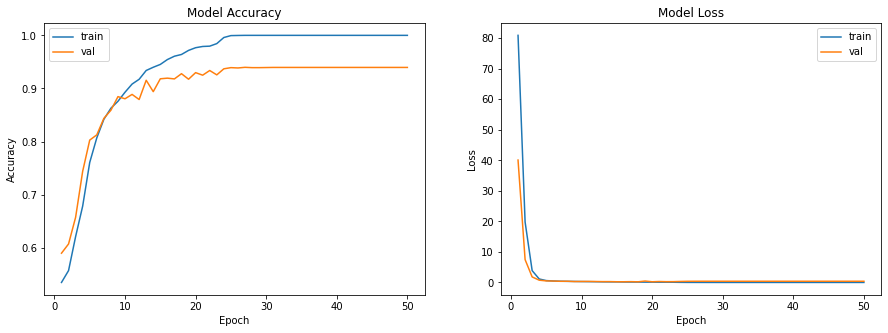

In [21]:
print('train loss:', history.history['loss'][-1])
print('train accuracy:', history.history['accuracy'][-1])

print('dev loss:', history.history['val_loss'][-1])
print('dev accuracy:', history.history['val_accuracy'][-1])

fig, axs = plt.subplots(1,2,figsize=(15,5))

axs[0].plot(range(1,len(history.history['accuracy'])+1), history.history['accuracy'])
axs[0].plot(range(1,len(history.history['val_accuracy'])+1),history.history['val_accuracy'])
axs[0].set_title('Model Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].legend(['train', 'val'], loc='best')

axs[1].plot(range(1,len(history.history['loss'])+1),history.history['loss'])
axs[1].plot(range(1,len(history.history['val_loss'])+1),history.history['val_loss'])
axs[1].set_title('Model Loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].legend(['train', 'val'], loc='best')

plt.show()

In [22]:
# test_loss, test_acc = model.evaluate(x_test, y_test)

In [23]:
# print('test loss:', test_loss)
# print('test accuracy:', test_acc)

In [24]:
predictions = model.predict(x_test)

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Ide

Executing op __inference_predict_function_80921 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_80921 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_80921 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_80921 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_80921 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_80921 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_80921 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_80921 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_80921 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_80921 in device /job:localhost/

Executing op __inference_predict_function_80921 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_80921 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_80921 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_80921 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_80921 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_80921 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_80921 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_80921 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_80921 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_80921 in device /job:localhost/

In [25]:
print(predictions)

y_pred = []

for i in predictions:
    if i[0] < i[1]:
        y_pred.append(1)
    else:
        y_pred.append(0)

[[9.99990463e-01 9.52987466e-06]
 [1.67737513e-09 1.00000000e+00]
 [1.00000000e+00 7.30114320e-12]
 ...
 [9.99999881e-01 1.06034854e-07]
 [9.99973536e-01 2.64393584e-05]
 [1.00000000e+00 2.07113915e-17]]


In [26]:
from sklearn.metrics import confusion_matrix

confusion_mtx = confusion_matrix(y_test, y_pred)

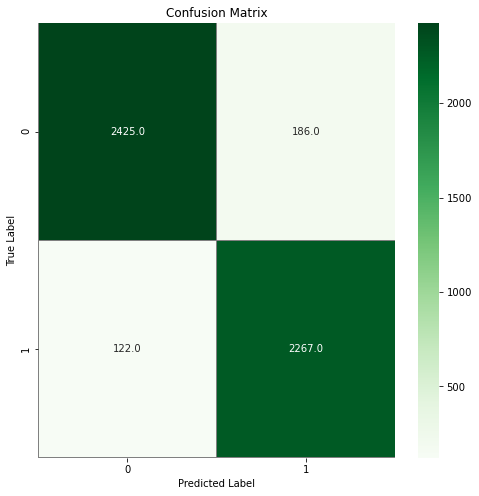

In [27]:
import seaborn as sns

f, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01, cmap="Greens",linecolor="gray", fmt='.1f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [28]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(y_test, y_pred, target_names=['cat', 'dog'])

In [29]:
print(report)

              precision    recall  f1-score   support

         cat       0.95      0.93      0.94      2611
         dog       0.92      0.95      0.94      2389

    accuracy                           0.94      5000
   macro avg       0.94      0.94      0.94      5000
weighted avg       0.94      0.94      0.94      5000



In [30]:
print('Precision:- Accuracy of positive predictions.')
print('Precision = TP/(TP + FP)')
print('Recall:- Fraction of positives that were correctly identified.')
print('Recall = TP/(TP+FN)')
print('F1 score')
print('F1 Score = 2*(Recall * Precision) / (Recall + Precision)')
print('Accuracy : (TP+TN) / all')
print('macro avg = (normal+abnormal)/2 * precision or recall or f1 score')
print('weighted avg = normal/(normal+abnormal) * precision or recall or f1 score')

Precision:- Accuracy of positive predictions.
Precision = TP/(TP + FP)
Recall:- Fraction of positives that were correctly identified.
Recall = TP/(TP+FN)
F1 score
F1 Score = 2*(Recall * Precision) / (Recall + Precision)
Accuracy : (TP+TN) / all
macro avg = (normal+abnormal)/2 * precision or recall or f1 score
weighted avg = normal/(normal+abnormal) * precision or recall or f1 score
